## Bias-variance trade off

### Generating data set

총 $L=100$개의 dataset이 주어진다. 각 dataset은 $N=25$개의 data point를 가지고 있으며, $h(x)=\sin(2\pi{x})$에 평균이 0, 표준편차가 0.3인 Gaussian noise가 더해진 형태를 가진다. 목표는 이 data point들로부터 원래의 $h(x)$의 모양을 예측해내는 것이다. 우선 필요한 패키지들을 import한다.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

x는 data point들의 x좌표를 나타내며, 구간 $[0,1]$을 25등분하는 점들을 나타낸다. t는 예측하고자 하는 target으로, (100, 25)의 shape를 가진다. 즉, t의 각 row가 한 개의 dataset을 나타낸다. 주어진 사인 함수에 평균이 0이고 표준편차가 0.3인 noise를 더해서 제작한다. 코딩의 편의성 상 우선 (100, 25) 모양의 Gaussian 난수를 포함하는 numpy array를 만들고, 각 row에 사인 함수를 더해서 제작했다. Dataset의 모양은 다음과 같은 형태이다.

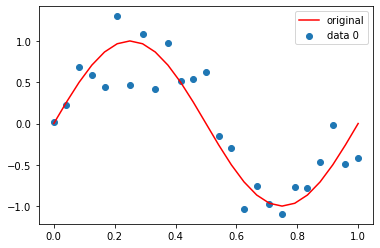

In [2]:
N = 25
L = 100

x = np.linspace(0, 1, N)
t = np.random.randn(L, N) * 0.3

for i in range(100):
    
    t[i] += np.array(list(map(lambda x: np.sin(2*np.pi*x), x)))

plt.scatter(x, t[0], label='data 0')
plt.plot(x, np.sin(2*np.pi*x), 'r-', label='original')
plt.legend()
plt.show()

### Goal of this notebook

PRML 교과서 3.2절에 등장하는 편향-분산 트레이드 오프(bias-variance trade off) 현상을 눈으로 확인한다. 이를 위해서 앞에서 정의한 것과 같은 문제를 푸는 것을 목표로 하되, regularization constant $\lambda$의 값에 따라 편향(bias)과 분산(variance)의 값이 어떻게 달라지는지 확인한다. 기본적으로, 여기에 작성된 코드는 PRML 169페이지의 설명을 따른다.

### Model

기본적으로, 24개의 Gaussian 기저 함수를 사용한 모델을 이용해, 식 (3.27)의 정규화 오류 함수를 최소화하는 방식으로 fitting을 진행한다. 

$$ \phi_{j}(x)=\exp\left(-\frac{(x-\mu_{j})^{2}}{2s^{2}}\right) $$

Gaussian 기저 함수가 총 24개 사용되므로, 그 중심에 해당되는 $\mu_{j}$는 $[0,1]$ 구간을 24등분하는 점으로 정했다. Gaussian 함수의 표준편차에 해당되는 $s$는 일종의 hyperparameter로, 시행착오 끝에 0.1이라는 값을 사용하였다. 이때 정규화 오류 함수는 다음과 같은 형태를 가진다.

$$ \frac{1}{2}\sum_{n=1}^{N}\{t_{n}-\vec{w}^{T}\vec{\phi}(\vec{x}_{n})\}^{2}+\frac{\lambda}{2}\vec{w}^{T}\vec{w} $$

식 (3.28)에 따르면 위의 정규화된 제곱합 오류 함수를 최소화하는 매개변수 벡터 $\vec{w}_{\text{ML}}$은 다음과 같이 주어진다.

$$ \vec{w}_{\text{ML}}=(\lambda\mathbf{I}+\Phi^{T}\Phi)^{-1}\Phi^{T}\mathbf{t} $$

이때 $\mathbf{t}=(t_{1},\cdots,t_{N})^{T}$를 의미하며, 설계 행렬(design matrix) $\Phi$는 식 (3.16)에 주어져 있다.

$$ \Phi_{ij}=\phi_{j}(x_{i}) $$

지금 풀고자 하는 문제에서는 매개변수 벡터의 변수 개수가 24개이고, 정규화 계수 $\lambda$까지 포함하더라도 25개에 불과하기 때문에 역행렬과 행렬곱을 포함한 $\vec{w}_{\text{ML}}$를 계산하는 과정이 그리 부담스럽지는 않다. 따라서 우선 $\vec{w}_{\text{ML}}$을 행렬 연산을 통해서 직접적으로 계산하는 방법을 살펴보고자 한다.

이 방법으로 계산한 이후에는, 정규화는 잠시 제쳐두고 SGD(Stochastic Gradient Descent) 방식으로 같은 문제를 푸는 것 또한 살펴볼 것이다.

In [3]:
def basis(x, mu, s):
    
    return np.exp(- pow((x-mu), 2) / (2 * pow(s,2)))

WeightVectorSize = 24
mu = np.linspace(0, 1, WeightVectorSize)
s = 0.1

이 문제를 풀기 위한 class를 하나 정의한다. \_\_init\_\_ 에서 weight의 초깃값을 random하게 설정해준다. Weight들은 $[0,1]$에서의 uniform distribution에서 추출되며, 음의 weight 또한 있는 것이 자연스럽기 때문에 전체적으로 0.5를 빼 주게 된다(이것은 SGD를 위해 존재하는 옵션이다).

In [4]:
class BiasVarianceTradeoff():
    
    def __init__(self, x, t, reg, mu, s):
        self.x = x
        self.t = t
        self.weight = np.random.rand(WeightVectorSize) - np.ones(WeightVectorSize) * 0.5
        self.reg = reg
        self.mu = mu
        self.s = s
    
    def train(self, l):
        
        target = t[l]
        
        def phi_col(i):
            
            return np.array([basis(x, self.mu[i], self.s) for x in self.x])
        
        Phi = np.zeros((N, 24), dtype="f")
        
        for i in range(24):
            
            Phi[:,i] = phi_col(i)
            
        w = np.linalg.inv(self.reg * np.eye(24) + np.transpose(Phi).dot(Phi)).dot(np.transpose(Phi))
        w = w.dot(target)
        
        return w
    
    def train_SGD(self, l, weight, data=N, lr=1e-3):
        
        w = weight
            
        for tau in range(data):
            
            phi = np.array([basis(x[tau], m, self.s) for m in self.mu])
            w += lr * (t[l,tau] - sum(w * phi)) * phi
        
        return w
    
    def pred_func(self, x, weight):
        
        phi = np.array([basis(x, m, self.s) for m in self.mu])
        
        return sum(weight * phi)

우선은, regularization parameter $\lambda$의 크기에 따라서 model의 예측이 어떻게 달라지는지를 살펴보고자 한다. 방식은 간단하다. 100개의 dataset에 대해서 각각 prediction 값을 얻고, 이를 평균을 내서 plot한다. 이를 위한 함수를 정의한다.

In [5]:
def averaging(model):
        
    x = np.linspace(0,1,1000)
    pred = np.zeros(1000)
    h = np.zeros((L, 1000), dtype="f")

    for l in tqdm(range(L), desc="dataset"):

        weight = model.train(l)
        h[l] = np.array([model.pred_func(xs, weight) for xs in x])
        pred += h[l]

    pred = pred / L
    
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    
    graph_num = 20
    plot_list = random.sample(range(100), graph_num)
    plt.title('Gaussian basis functions')
    plt.xlim(-0.02,1.02)
    plt.ylim(-1.5,1.5)
    
    for l in plot_list:
        
        plt.plot(x, h[l], 'r-', linewidth='0.5')
    
    plt.subplot(1,2,2)
    
    plt.title('Curve fit')
    plt.plot(x, pred, label='prediction')
    plt.plot(x, np.sin(2*np.pi*x), label='real')
    plt.xlim(-0.02,1.02)
    plt.ylim(-1.5,1.5)
    
    plt.show()

dataset: 100%|██████████| 100/100 [00:04<00:00, 22.19it/s]


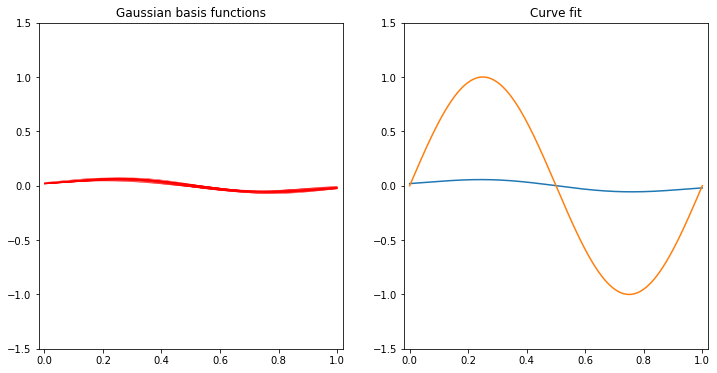

In [6]:
reg1 = pow(10, 2.6)
model1 = BiasVarianceTradeoff(x, t, reg1, mu, s)
averaging(model1)

dataset: 100%|██████████| 100/100 [00:04<00:00, 22.23it/s]


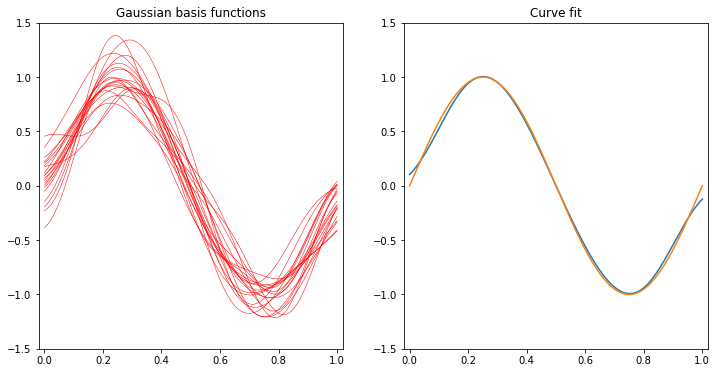

In [7]:
reg2 = pow(10, -0.31)
model2 = BiasVarianceTradeoff(x, t, reg2, mu, s)
averaging(model2)

dataset: 100%|██████████| 100/100 [00:04<00:00, 22.20it/s]


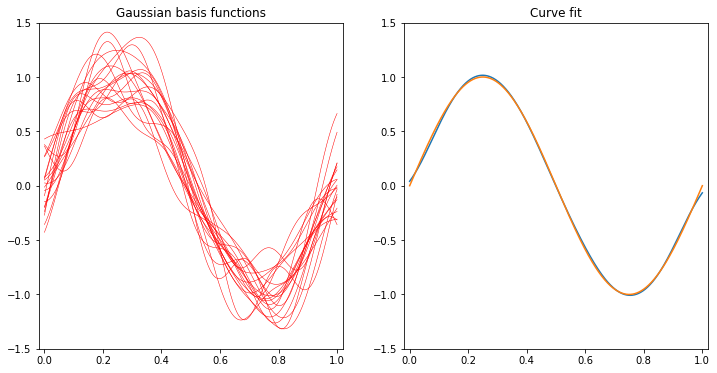

In [8]:
reg3 = pow(10, -2.4)
model3 = BiasVarianceTradeoff(x, t, reg3, mu, s)
averaging(model3)

반면, 정규화는 잠시 제쳐두고 SGD를 사용할 수도 있다. 데이터의 개수가 너무 많은 경우에는 순차적인 gradient descent를 사용하지 않을 수 없다.

In [9]:
def averaging_SGD(model, repeat):
        
    x = np.linspace(0,1,1000)
    pred = np.zeros(1000)

    for l in tqdm(range(L), desc="dataset"):

        idx = 0
        weight = model.weight
        for idx in range(repeat):
            weight = model.train_SGD(l, weight)
        pred += np.array([model.pred_func(xs, weight) for xs in x])

    pred = pred / L

    plt.plot(x, pred, label='prediction')
    plt.plot(x, np.sin(2*np.pi*x), label='real')
    plt.show()

dataset: 100%|██████████| 100/100 [00:05<00:00, 18.65it/s]


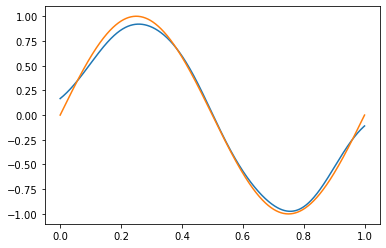

In [10]:
averaging_SGD(model1, 10)

### Bias-variance trade off

이제, 편향-분산 트레이드 오프를 수치적으로 확인해 보자. 평균 예측치는 다음으로부터 추산된다.

$$ \bar{y}=\frac{1}{L}\sum_{i=1}^{L}y^{(l)}(x) $$

편향(bias)과 분산(variance)도 다음처럼 주어진다.

$$ (\text{bias})^{2}=\frac{1}{N}\sum_{n=1}^{N}\{\bar{y}(x_{n})-h(x_{n})\}^{2} $$

$$ \text{variance}=\frac{1}{N}\sum_{n=1}^{N}\frac{1}{L}\sum_{l=1}^{L}\{y^{(l)}(x_{n})-\bar{y}(x_{n})\}^{2} $$

In [11]:
N = 25
L = 100

x = np.linspace(0, 1, N)
t = np.random.randn(L, N) * 0.3
y = np.zeros((L, N), dtype="f")

for i in range(100):
    
    t[i] += np.array(list(map(lambda x: np.sin(2*np.pi*x), x)))

ln_reg = np.linspace(-2.5,2.0,100)
reg = np.exp(ln_reg)

regularization constant: 100%|██████████| 100/100 [00:22<00:00,  4.36it/s]


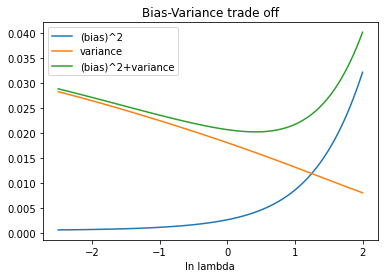

In [12]:
bias_list = []
var_list = []

for r in tqdm(reg, desc='regularization constant'):
    
    model = BiasVarianceTradeoff(x, t, r, mu, s)
    y_mean = np.zeros(N)
    
    for l in range(L):
        
        weight = model.train(l)
        y[l] = np.array([model.pred_func(xs, weight) for xs in x])
        y_mean += y[l]
    
    y_mean = y_mean / L
    
    diff = y_mean - np.array([np.sin(2*np.pi*xs) for xs in x])
    bias = np.linalg.norm(diff) ** 2 / N
    
    var = 0
    
    for l in range(L):
        
        var += np.linalg.norm(y[l] - y_mean) ** 2
    
    var = var / (N*L)
    bias_list.append(bias)
    var_list.append(var)
    
bias_var_list = [b+v for b,v in zip(bias_list,var_list)]
    
plt.plot(ln_reg, bias_list, label='(bias)^2')
plt.plot(ln_reg, var_list, label='variance')
plt.plot(ln_reg, bias_var_list, label='(bias)^2+variance')
plt.title('Bias-Variance trade off')
plt.xlabel('ln lambda')
plt.legend()

plt.show()